In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil

# Constants
data_dir = r'C:\Users\ismai\OneDrive\Desktop\iMAGE_PROCESSING\tom_and_jerry\Dataset'
temp_data_dir = r'C:\Users\ismai\OneDrive\Desktop\iMAGE_PROCESSING\tom_and_jerry\Temp_Dataset'
processed_data_dir = r'C:\Users\ismai\OneDrive\Desktop\iMAGE_PROCESSING\tom_and_jerry\Processed_Dataset'
saved_model_dir = r'C:\Users\ismai\OneDrive\Desktop\iMAGE_PROCESSING\tom_and_jerry\Attempt4_results'

# Create a temporary directory excluding the 'tom_jerry_0' subfolder
if os.path.exists(temp_data_dir):
    shutil.rmtree(temp_data_dir)
shutil.copytree(data_dir, temp_data_dir, ignore=shutil.ignore_patterns('tom_jerry_0'))


'C:\\Users\\ismai\\OneDrive\\Desktop\\iMAGE_PROCESSING\\tom_and_jerry\\Temp_Dataset'

In [2]:
# Preprocess Images
def preprocess_images(data_dir, output_dir, image_size):
    subfolders = ['tom', 'jerry', 'tom_jerry_1']  # Define the subfolders
    
    for subfolder in subfolders:
        folder_path = os.path.join(data_dir, subfolder)
        output_subfolder = os.path.join(output_dir, subfolder)
        os.makedirs(output_subfolder, exist_ok=True)
        
        image_files = os.listdir(folder_path)
        for image_file in tqdm(image_files, desc=f"Processing {subfolder} images"):
            image_path = os.path.join(folder_path, image_file)
            img = cv2.imread(image_path)
            
            if subfolder == 'tom':
                img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                lower_range = np.array([100, 50, 50])
                upper_range = np.array([130, 255, 255])
                mask = cv2.inRange(img_hsv, lower_range, upper_range)
            elif subfolder == 'jerry':
                img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                lower_range = np.array([0, 100, 100])
                upper_range = np.array([10, 255, 255])
                mask = cv2.inRange(img_hsv, lower_range, upper_range)
            elif subfolder == 'tom_jerry_1' or subfolder == 'tom_jerry_0':
                img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                lower_range_jerry = np.array([0, 100, 100])
                upper_range_jerry = np.array([10, 255, 255])
                lower_range_tom = np.array([100, 50, 50])
                upper_range_tom = np.array([130, 255, 255])
                
                mask_jerry = cv2.inRange(img_hsv, lower_range_jerry, upper_range_jerry)
                mask_tom = cv2.inRange(img_hsv, lower_range_tom, upper_range_tom)
                mask = cv2.bitwise_or(mask_jerry, mask_tom)
            else:
                continue  # Skip processing for unknown subfolders

            # For 'tom_jerry_0', normalize and resize the image
            if subfolder == 'tom_jerry_0':
                img_resized = cv2.resize(img, image_size)
                img_normalized = cv2.normalize(img_resized, None, 0, 255, cv2.NORM_MINMAX)
                output_path = os.path.join(output_subfolder, image_file)
                cv2.imwrite(output_path, img_normalized)
                continue

            # Apply morphological operations
            kernel = np.ones((3, 3), np.uint8)
            mask_opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask_closed = cv2.morphologyEx(mask_opened, cv2.MORPH_CLOSE, kernel)
            
            # Add edge detection to enhance mask
            edges = cv2.Canny(img, 100, 200)
            edges_dilated = cv2.dilate(edges, kernel, iterations=1)
            combined_mask = cv2.bitwise_or(mask_closed, edges_dilated)
            
            # Save the processed mask
            output_path = os.path.join(output_subfolder, image_file)
            cv2.imwrite(output_path, combined_mask)

# Preprocess the images
image_size = (75, 75)
preprocess_images(data_dir, processed_data_dir, image_size)

Processing tom_jerry_1 images: 100%|█████████████████████████████████████████████████| 780/780 [00:10<00:00, 75.63it/s]


In [3]:
# Load Data
batch_size = 32
img_height = 75
img_width = 75

train_ds = tf.keras.utils.image_dataset_from_directory(
    processed_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    processed_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Number of classes
num_classes = len(train_ds.class_names)
print("Number of Classes:", num_classes)

# InceptionV3 Model
pre_trained_model = InceptionV3(input_shape=(75, 75, 3), include_top=False, weights="imagenet")
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

model_inception = Model(pre_trained_model.input, x)
model_inception.compile(optimizer=RMSprop(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['acc'])

# Custom Callback to Track Learning Rate and Error Rate
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []
        self.error_rates = []
        self.accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        error_rate = 1 - logs['acc']
        accuracy = logs['acc']
        self.learning_rates.append(lr.numpy())
        self.error_rates.append(error_rate)
        self.accuracies.append(accuracy)
        print(f"Epoch {epoch+1}: Learning Rate: {lr.numpy()}, Error Rate: {error_rate}, Accuracy: {accuracy}")

custom_callback_inception = CustomCallback()

# Train Model with Custom Callback
history_inception = model_inception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[custom_callback_inception]
)


Found 3950 files belonging to 3 classes.
Using 3160 files for training.
Found 3950 files belonging to 3 classes.
Using 790 files for validation.
Number of Classes: 3
Epoch 1/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.4263 - loss: 21.9290Epoch 1: Learning Rate: 0.0005000000237487257, Error Rate: 0.5408227741718292, Accuracy: 0.4591772258281708
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - acc: 0.4266 - loss: 21.8119 - val_acc: 0.5582 - val_loss: 3.0778
Epoch 2/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.5078 - loss: 3.0281Epoch 2: Learning Rate: 0.0005000000237487257, Error Rate: 0.5088607668876648, Accuracy: 0.4911392331123352
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - acc: 0.5077 - loss: 3.0245 - val_acc: 0.4595 - val_loss: 1.1222
Epoch 3/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.4923 - loss: 1.7077Epoch 3: Learning Rate: 0.0005000000237487257, Error Rate: 0.5, Accuracy: 0.5
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - acc: 0.4924 - loss: 1.7059 - val_acc: 0.6076 

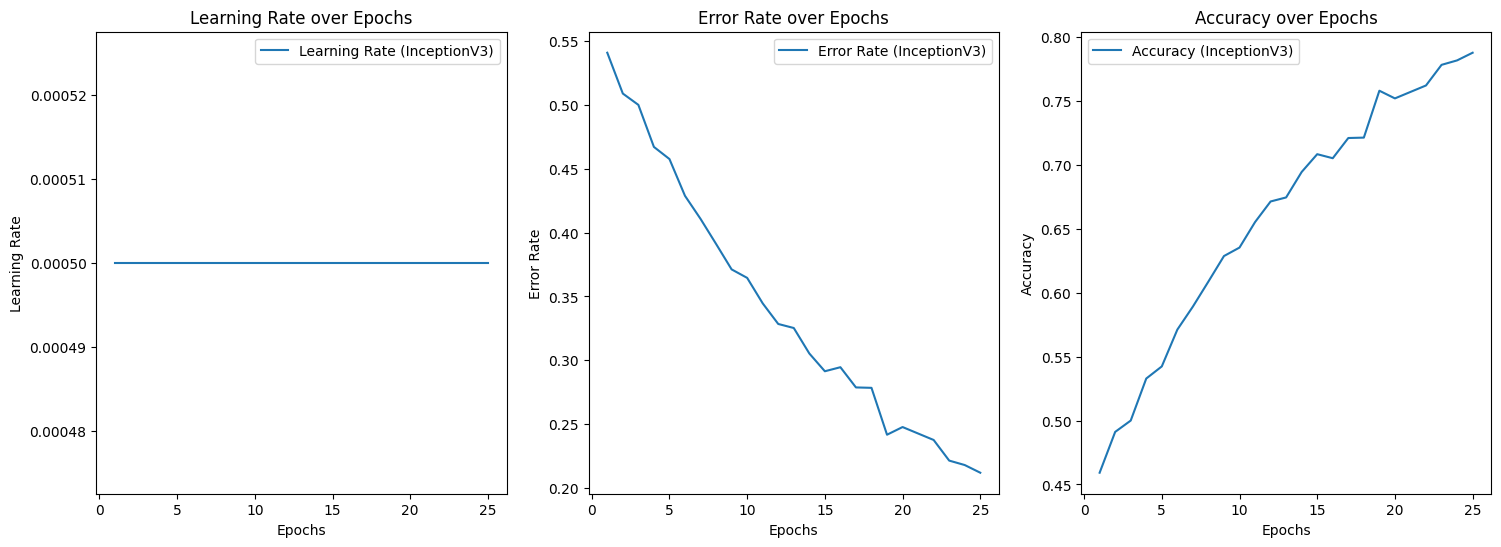

In [4]:
# Plot Learning Rate, Error Rate, and Accuracy
epochs_range = range(1, 26)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, custom_callback_inception.learning_rates, label='Learning Rate (InceptionV3)')
plt.legend(loc='upper right')
plt.title('Learning Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, custom_callback_inception.error_rates, label='Error Rate (InceptionV3)')
plt.legend(loc='upper right')
plt.title('Error Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, custom_callback_inception.accuracies, label='Accuracy (InceptionV3)')
plt.legend(loc='upper left')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - acc: 0.8656 - loss: 0.3522
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - acc: 0.7517 - loss: 0.7634
InceptionV3 Training accuracy: 0.8708860874176025
InceptionV3 Testing accuracy: 0.753164529800415
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━

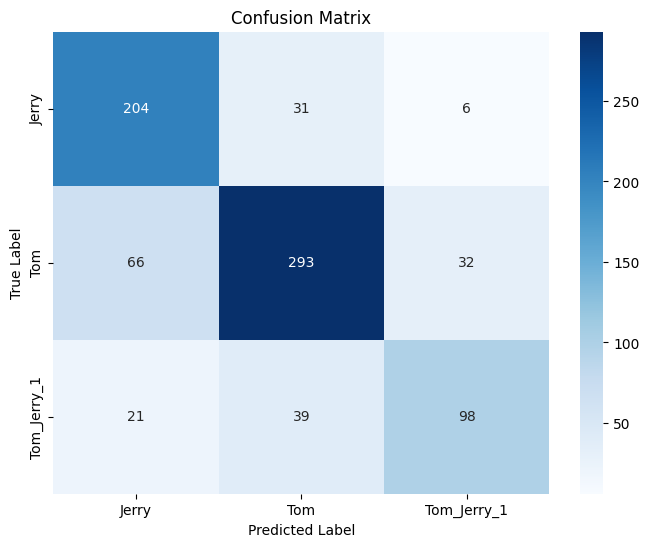

In [5]:
# Evaluate Model
train_loss, train_acc = model_inception.evaluate(train_ds)
test_loss, test_acc = model_inception.evaluate(val_ds)
print("InceptionV3 Training accuracy:", train_acc)
print("InceptionV3 Testing accuracy:", test_acc)

# Save Model
model_inception.save(os.path.join(saved_model_dir, "inception_trained.keras"))

# Collect all true labels and predictions
true_labels = []
inception_predictions = []

for images, labels in val_ds:
    true_labels.extend(labels.numpy())
    inception_predictions.extend(model_inception.predict(images))

true_labels = np.array(true_labels)
inception_predictions = np.array(inception_predictions)

# Class Predictions
inception_class_preds = np.argmax(inception_predictions, axis=1)

# Verify number of classes
num_classes = len(np.unique(true_labels))
print(f"Number of Classes: {num_classes}")

# Adjust label categories if necessary
label_categories = {
    0: "Jerry",
    1: "Tom",
    2: "Tom_Jerry_1"
}

# Ensure the target names match the number of classes
target_names = [label_categories[i] for i in range(num_classes)]

# Classification Report
print("InceptionV3 Classification Report:")
print(classification_report(true_labels, inception_class_preds, target_names=target_names))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(true_labels, inception_class_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()